# Button network

This is a demonstration of the [agentpy](https://agentpy.readthedocs.io) package, presenting an agent-based model of randomly connecting buttons. 
It shows how to work with networks and how to visualize averaged time-series for discrete parameter samples. 

A [similar model](http://agentbase.org/model.html?f4c4388138450bdf9732) has been built by Wybo Wiersma in [Agentbase](http://agentbase.org/model.html?f4c4388138450bdf9732), allowing for a comparison between the two frameworks. The idea for the model is based on the following analogy from [Stuart Kauffman](http://www.pbs.org/lifebeyondearth/resources/intkauffmanpop.html): 

> "Suppose you take 10,000 buttons and spread them out on a hardwood floor. You have a large spool of red thread. Now, what you do is you pick up a random pair of buttons and you tie them together with a piece of red thread. Put them down and pick up another random pair of buttons and tie them together with a red thread, and you just keep doing this. Every now and then lift up a button and see how many buttons you've lifted with your first button. A connective cluster of buttons is called a cluster or a component. When you have 10,000 buttons and only a few threads that tie them together, most of the times you'd pick up a button you'll pick up a single button. 
>
>As the ratio of threads to buttons increases, you're going to start to get larger clusters, three or four buttons tied together; then larger and larger clusters. At some point, you will have a number of intermediate clusters, and when you add a few more threads, you'll have linked up the intermediate-sized clusters into one giant cluster.
>
>So that if you plot on an axis, the ratio of threads to buttons: 10,000 buttons and no threads; 10,000 buttons and 5,000 threads; and so on, you'll get a curve that is flat, and then all of a sudden it shoots up when you get this giant cluster. This steep curve is in fact evidence of a phase transition.
>
>If there were an infinite number of threads and an infinite number of buttons and one just tuned the ratios, this would be a step function; it would come up in a sudden jump. So it's a phase transition like ice freezing.
>
>Now, the image you should take away from this is if you connect enough buttons all of a sudden they all go connected. To think about the origin of life, we have to think about the same thing."

In [1]:
# Import libraries

import agentpy as ap
import networkx as nx
import seaborn as sns
import random

In [2]:
# Define the model

class button_model(ap.Model):
    
    def setup(self):
        
        # Create a graph with n agents
        self.add_network('buttons')
        self.buttons.add_agents(self.p.n)
        self.threads = 0
        
    def update(self):
        
        # Record size of the biggest cluster
        clusters = nx.connected_components(self.buttons.graph)
        max_cluster_size = max([len(g) for g in clusters]) / self.p.n
        self.record('max_cluster_size', max_cluster_size)
        
        # Record threads to button ratio
        self.record('threads_to_button', self.threads / self.p.n)
 
    def step(self):
        
        # Create random edges based on parameters
        for _ in range(int(self.p.n * self.p.speed)):  
            self.buttons.add_edge(*self.agents.random(2))
            self.threads += 1         

In [3]:
# Define parameter ranges

parameter_ranges = {
    'steps': 30,  # Number of simulation steps
    'speed': 0.05,  # Speed of connections per step
    'n': (10,100,500,1000,10000)  # Number of agents, given in a discrete range
    }

In [4]:
# Perform simulation

sample = ap.sample_discrete(parameter_ranges) # Create sample for different values of n
exp = ap.Experiment(button_model, sample, iterations = 25, record = True) # Keep dynamic variables
results = exp.run() # Perform 125 seperate simulations ( 5 parameter combinations * 25 repetitions )

Scheduled runs: 125
Completed: 125, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:00:39.260928


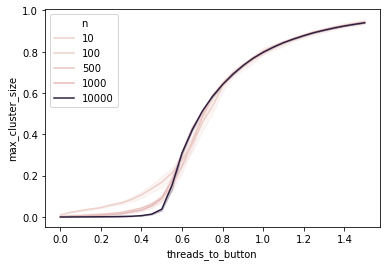

In [5]:
# Plot results

data = results.arrange_variables() # Create plotting data
ax = sns.lineplot(data=data, x='threads_to_button', y='max_cluster_size', hue='n')

We can see that, in line with Kauffman's argumentation, the variable stays low and then shoots up quite suddenly at a treshold of 0.5 if the number of buttons is high. However, in contrast to Kauffman's claim, the function does not converge towards a step function as the steepness of the curve declines later on independent of the number of buttons.